# Template for analyzing the CLM5-PPE
- Updated Oct 2, 2023
- geared towards the latin hypercube ensemble
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [4]:
from utils import *

In [2]:
# Setup your PBSCluster
# only run this cell once!
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300641', # Input your project ID here
    walltime='00:30:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [7]:
%%time
dvs=['TLAI','GPP','NBP']
ds=get_exp('lhc',dvs=dvs,yy=[1980,2014])
la=xr.open_dataset('sparsegrid_landarea.nc').landarea

CPU times: user 23.9 s, sys: 1.51 s, total: 25.4 s
Wall time: 2min


In [8]:
%%time
lai=amean(gmean(ds.TLAI,la))
laitrend=lai.polyfit(dim='year',deg=1).polyfit_coefficients.sel(degree=1)
cf=1e-9*24*60*60*365*la.sum()
nbp=cf*amean(gmean(ds.NBP,la)).sum(dim='year')

CPU times: user 1min 4s, sys: 3.99 s, total: 1min 8s
Wall time: 2min 21s


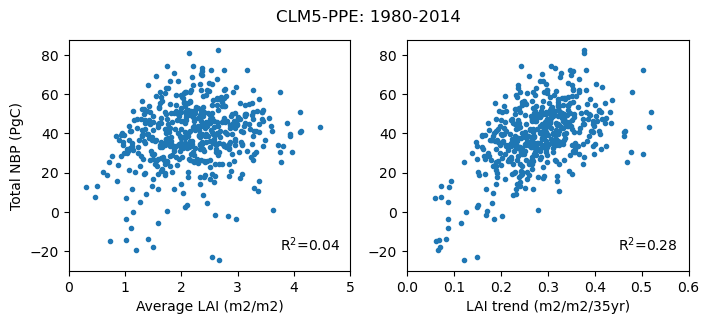

In [9]:
fig=plt.figure(figsize=[8,3])
plt.subplot(121)
plt.plot(lai.mean(dim='year'),nbp,'.');
plt.xlim([0,5])
plt.ylabel('Total NBP (PgC)')
plt.xlabel('Average LAI (m2/m2)')
r=np.corrcoef(lai.mean(dim='year'),nbp)[0,1]
plt.text(15/4,-20,'R$^2$='+str(np.round(r**2,2)))
plt.subplot(122)
plt.plot(35*laitrend,nbp,'.');
plt.xlim([0,0.6])
plt.xlabel('LAI trend (m2/m2/35yr)')
r=np.corrcoef(laitrend,nbp)[0,1]
plt.text(0.45,-20,'R$^2$='+str(np.round(r**2,2)))
fig.suptitle('CLM5-PPE: 1980-2014');

In [10]:
laiavg=lai.mean(dim='year')
dlai=[abs(laiavg.isel(ens=ds[p]>0.8).mean()-laiavg.isel(ens=ds[p]<0.2).mean()).values for p in ds.param.values]

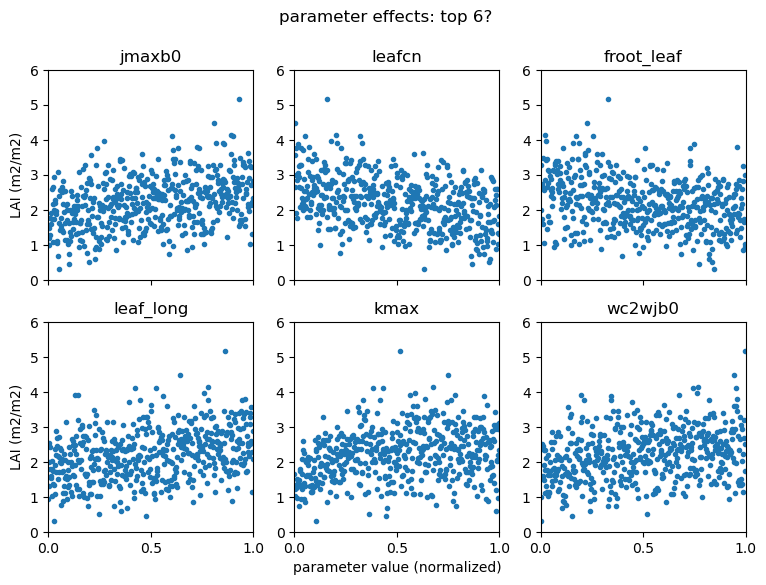

In [11]:
fig=plt.figure(figsize=[9,6])
ix=np.argsort(dlai)[-6:]
for i,p in enumerate(np.flipud(ds.param[ix])):
    plt.subplot(2,3,i+1)
    plt.plot(ds[p],laiavg,'.')
    plt.ylim([0,6])
    plt.xlim([0,1])
    if i>=3:
        plt.xticks(np.arange(3)/2)
    else:
        plt.xticks(np.arange(3)/2,[])
    plt.title(p)
    
    if i==4:
        plt.xlabel('parameter value (normalized)')
    if i%3==0:
        plt.ylabel('LAI (m2/m2)')
        
fig.suptitle('parameter effects: top 6?');
